In [20]:
import pymongo

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import csv

import re

pattern = re.compile(
    r"(github\.com|bitbucket\.org|gitlab\.com)/[a-zA-Z0-9_\.\-]+/[a-zA-Z0-9_\.\-]+"
)

db = pymongo.MongoClient('mongodb://127.0.0.1:27017')['radar']
col = db['release_metadata']
docs = col.find()

# project urls中的优先级问题

- 思路1: metadata有优先级的, 前面的成功了就直接结束, 如果homepage, download_url这些匹配代码托管平台成功了, 就直接结束, 接着再看其他的code相关, 然后看bug相关, 最后看doc相关等等

- 思路2: 是根据分析结果调整metadata, badge等的权重, 粒度更细一些

- 并且可以定期统计, 动态调整 => 提高竞争力\卖点

这样做的话存在一个假设: 即是

```python
pattern = re.compile(
    r"(github\.com|bitbucket\.org|gitlab\.com)/[a-zA-Z0-9_\.\-]+/[a-zA-Z0-9_\.\-]+"
)

这样如果打乱project_urls的顺序, 匹配结果不同

且不同的比例不低

```


## project_urls的field分布

[napari-svetlana](https://pypi.org/project/napari-svetlana/)以及[pubmed2pdf](https://pypi.org/project/pubmed2pdf/)的例子, Bug Tracker, User Support, Documentation也可以得到 ⇒ 直接在所有project_urls匹配得了?

首先需要对project_urls的field分布进行分析 => 还有哪些corner case? 还能有哪些好的field? 能不能试试性能不错的模糊匹配? 

In [8]:
project_url_field_counts = {}

for doc in docs:
    project_urls = doc["project_urls"]
    if isinstance(project_urls, dict):
        project_url_fields = project_urls.keys()
        for project_url_field in project_url_fields:
            project_url_field = project_url_field.lower().replace(' ', '_').replace('-', '_')
            if project_url_field in project_url_field_counts:
                project_url_field_counts[project_url_field] += 1
            else:
                project_url_field_counts[project_url_field] = 1
    
project_url_field_counts = sorted(project_url_field_counts.items(), key=lambda x: x[1], reverse=True)
project_url_field_counts = {item[0]: item[1] for item in project_url_field_counts}
print(project_url_field_counts)

{'homepage': 3762399, 'download': 777089, 'source': 398666, 'documentation': 361679, 'tracker': 178122, 'repository': 158933, 'bug_tracker': 153083, 'source_code': 69892, 'bug_reports': 37100, 'issue_tracker': 31179, 'changelog': 27114, 'issues': 17667, 'funding': 12468, 'github': 10969, 'code': 9427, 'twitter': 6650, 'contribute!': 6209, 'forum': 6201, 'say_thanks!': 5036, 'home': 4914, 'website': 4192, 'discord': 4060, 'pypi': 3552, 'changes': 3226, 'chat': 2654, 'ci': 2595, 'youtube': 2513, 'docs': 2160, 'blog': 1920, 'release_notes': 1910, 'slack_chat': 1845, 'slack': 1778, 'gitter': 1682, 'discussions': 1665, 'user_support': 1599, 'github:_repo': 1405, 'github:_issues': 1384, 'releases': 1348, 'dev_docs': 1324, 'community': 1215, 'change_log': 1046, 'wiki': 980, 'docker': 938, 'donate': 893, 'icon': 888, 'examples': 875, 'docs:_rtd': 869, 'read_the_docs': 678, 'code_of_conduct': 677, 'mailing_lists': 651, 'sources': 638, 'support': 611, 'github_repository': 595, 'home_page': 528, 

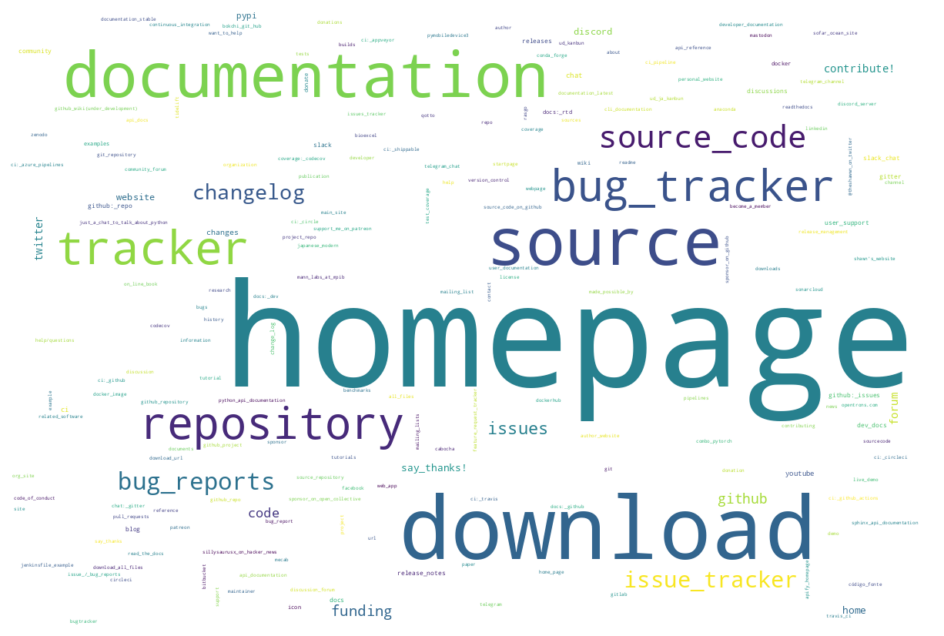

In [9]:
wordcloud = WordCloud(width=1200, height=800, background_color="white").generate_from_frequencies(project_url_field_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.show()

## 自动化分析: 通过正则表达式

bug tracker等field的url匹配包含代码托管平台关键词, 自动化分析:

- 自动化分析的思路: 

    - 在`project_urls`中通过正则匹配, 匹配成功则保存field

    - 将field标准化: 全转小写, 空格转为`_`
    
    - 排序

In [3]:
docs = col.find()



project_url_match_platform = {}

for doc in docs:
    project_urls = doc["project_urls"]
    if isinstance(project_urls, dict):
        for key, value in project_urls.items():
            if pattern.search(value):
                key = key.lower().replace(' ', '_').replace('-', '_')
                if key in project_url_match_platform:
                    project_url_match_platform[key] += 1
                else:
                    project_url_match_platform[key] = 1
    
project_url_match_platform = sorted(project_url_match_platform.items(), key=lambda x: x[1], reverse=True)
project_url_match_platform = {item[0]: item[1] for item in project_url_match_platform}
print(project_url_match_platform)

{'homepage': 3036822, 'source': 393287, 'download': 260340, 'tracker': 177187, 'repository': 154746, 'bug_tracker': 141784, 'source_code': 64503, 'documentation': 36935, 'bug_reports': 34676, 'issue_tracker': 30698, 'changelog': 20536, 'issues': 17211, 'github': 10505, 'code': 9270, 'contribute!': 6209, 'home': 3905, 'changes': 2861, 'funding': 2634, 'ci': 2130, 'discussions': 1411, 'user_support': 1399, 'github:_repo': 1389, 'github:_issues': 1368, 'release_notes': 1110, 'releases': 798, 'wiki': 761, 'examples': 687, 'change_log': 598, 'github_repository': 593, 'sources': 566, 'ci:_github_actions': 446, 'say_thanks!': 442, 'docs': 428, 'license': 364, 'pull_requests': 353, 'source_repository': 352, 'release_management': 350, 'home_page': 344, 'source_code_on_github': 333, 'donate': 323, 'gitlab': 316, 'bugs': 314, 'ci:_github': 283, 'issue_/_bug_reports': 274, 'version_control': 260, 'continuous_integration': 237, 'url': 231, 'bugtracker': 228, 'feature_request_tracker': 207, 'website

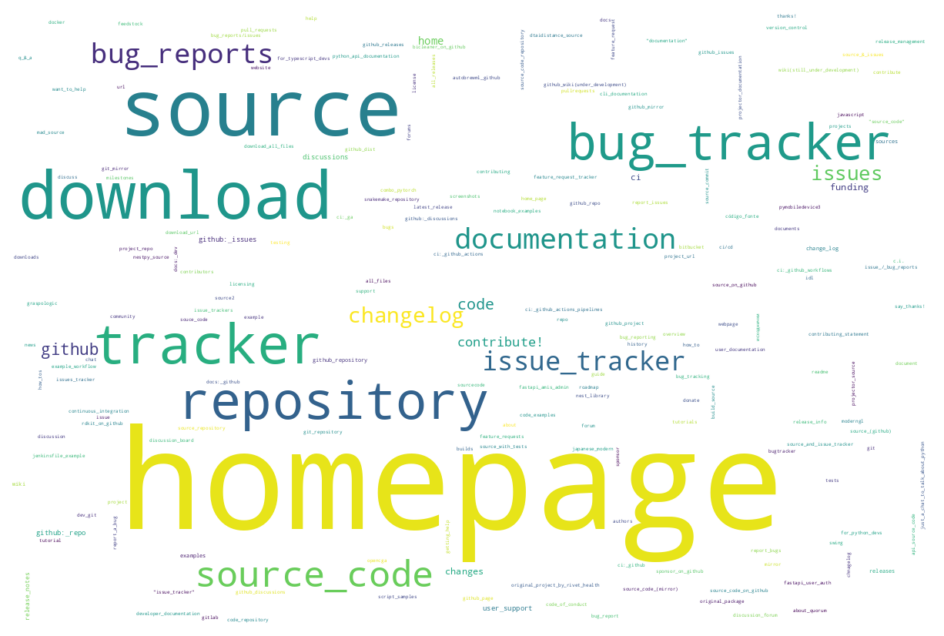

In [10]:
wordcloud = WordCloud(width=1200, height=800, background_color="white").generate_from_frequencies(project_url_match_platform)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.show()

比较一下, 我们既然已经有了field非空和field url 成功匹配代码托管平台, 不妨计算一下匹配成功的比例

In [18]:
project_url_match_rate = {}

for key, value in project_url_match_platform.items():
    rate = value / project_url_field_counts[key]
    project_url_match_rate[key] = rate
    
print(project_url_match_rate)

project_url_match_rate = sorted(project_url_match_rate.items(), key=lambda x: x[1], reverse=True)
project_url_match_rate = {item[0]: item[1] for item in project_url_match_rate}
print(project_url_match_rate)

{'homepage': 0.807150437792483, 'source': 0.9865075025209072, 'download': 0.3350195408762703, 'tracker': 0.9947507887852146, 'repository': 0.9736555655527801, 'bug_tracker': 0.9261903673170764, 'source_code': 0.9228953242145024, 'documentation': 0.10212094149784753, 'bug_reports': 0.9346630727762804, 'issue_tracker': 0.9845729497418134, 'changelog': 0.7573947038430331, 'issues': 0.9741891662421464, 'github': 0.9576989698240496, 'code': 0.9833457091333404, 'contribute!': 1.0, 'home': 0.7946682946682947, 'changes': 0.8868567885926845, 'funding': 0.21126082771896054, 'ci': 0.8208092485549133, 'discussions': 0.8474474474474475, 'user_support': 0.8749218261413383, 'github:_repo': 0.9886120996441281, 'github:_issues': 0.9884393063583815, 'release_notes': 0.581151832460733, 'releases': 0.5919881305637982, 'wiki': 0.7765306122448979, 'examples': 0.7851428571428571, 'change_log': 0.5717017208413002, 'github_repository': 0.9966386554621849, 'sources': 0.8871473354231975, 'ci:_github_actions': 1.

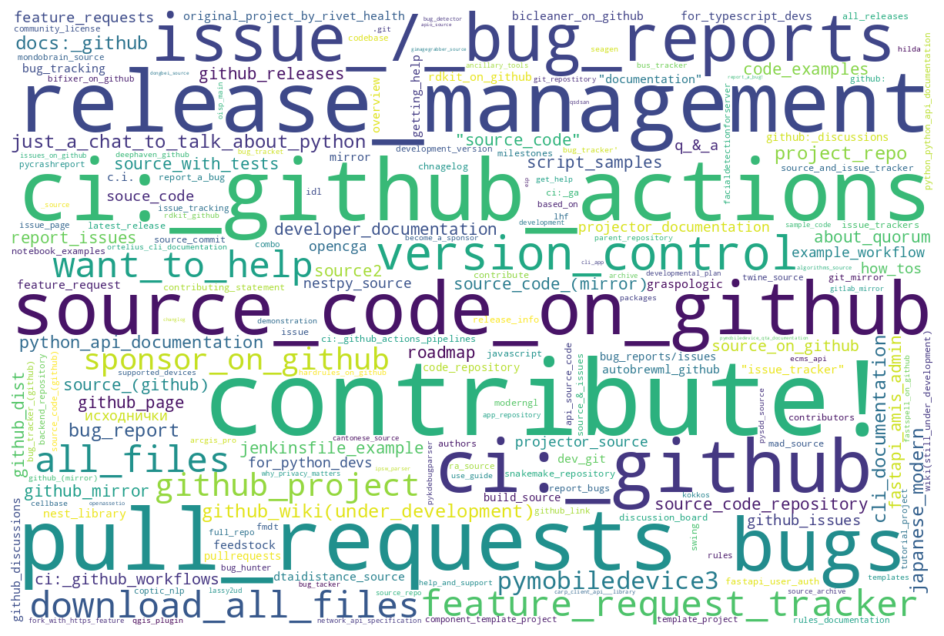

In [19]:
wordcloud = WordCloud(width=1200, height=800, background_color="white").generate_from_frequencies(project_url_match_rate)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.show()

## 每个project_urls能用正则匹配到几种不同的url? 

分别占比多少? 输出到文件中, 选择其中一部分看一看是咋回事

可以看到:

- 2种platform urls有2.6w

- 去掉 https://github.com/sponsors (2706个), https://github.com/pypa/sampleprojec (1154个), https://github.com/user/reponame (780个)

In [21]:
removed_urls = ["https://github.com/sponsors", "https://github.com/pypa/sampleprojec", "https://github.com/user/reponame"]

filename = "project_urls_platform_type_counts.csv"

project_urls_platform_type_counts = {}

with open(filename, 'w', newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(["count", "matched_urls"])

    for doc in docs:
        project_urls = doc["project_urls"]
        if isinstance(project_urls, dict):
            matched_urls = set()
            for key, value in project_urls.items():
                match = pattern.search(value)
                if match:
                    url = "https://" + match.group(0).lower()
                    url = url.rstrip(".git")
                    remove = False
                    for removed_url in removed_urls:
                        if removed_url in url: 
                            remove = True
                    if not remove:
                        matched_urls.add(url)
            count = len(matched_urls)
            if count > 1:
                row = [count, doc['name'], doc['version'], matched_urls]
                writer.writerow(row)
            if count in project_urls_platform_type_counts:
                project_urls_platform_type_counts[count] += 1
            else:
                project_urls_platform_type_counts[count] = 1
            
print(project_urls_platform_type_counts)

{1: 3161005, 0: 618159, 2: 21446, 3: 429, 5: 12, 4: 19}
